# Learning to Dampen the Duffing Oscillator

In this notebook we will explore training a neural network to dampen a Simple Harmonic Oscillator

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt

import copy
import desolver as de
import torch

Using `autoray` backend


## Specifying the Dynamical System

Now let's specify the right hand side of our dynamical system. It should be

$$
\ddot x + \delta\dot x + \alpha x + \beta x^3 = \gamma\cos(\omega t)
$$

But desolver only works with first order differential equations, thus we must cast this into a first order system before we can solve it. Thus we obtain the following system

$$
\begin{array}{l}
\frac{\mathrm{d}x}{\mathrm{dt}} = v_x \\
\frac{\mathrm{d}v_x}{\mathrm{dt}} = -\delta v_x - \alpha x - \beta x^3 + \gamma\cos(\omega t)
\end{array}
$$

In [2]:
@de.rhs_prettifier(
    equ_repr="[vx, -k*x/m]",
    md_repr=r"""
$$
\frac{\mathrm{d}y}{\mathrm{dt}} = \begin{bmatrix}
   0            & 1 \\
   -\frac{k}{m} & 0
   \end{bmatrix} \cdot \vec y
$$
"""
)
def rhs(t, state, k, m):
    return torch.stack([state[...,1], -k/m*state[...,0]], dim=-1)

In [3]:
print(rhs)
display(rhs)


$$
\frac{\mathrm{d}y}{\mathrm{dt}} = \begin{bmatrix}
   0            & 1 \\
   -\frac{k}{m} & 0
   \end{bmatrix} \cdot \vec y
$$




$$
\frac{\mathrm{d}y}{\mathrm{dt}} = \begin{bmatrix}
   0            & 1 \\
   -\frac{k}{m} & 0
   \end{bmatrix} \cdot \vec y
$$


Let's specify the initial conditions as well

In [4]:
y_init = torch.tensor([1., 0.], dtype=torch.float64)

And now we're ready to integrate!

## The Numerical Integration

We will use the same constants from Wikipedia as our constants where the forcing amplitude increases and all the other parameters stay constants.

In [5]:
#Let's define the fixed constants

constants = dict(
    k = 1.0,
    m = 1.0
)

# The period of the system
T = 2*torch.pi*(constants['m']/constants['k'])**0.5

# Initial and Final integration times
t0 = 0.0
tf = 40*T

In [6]:
a = de.OdeSystem(rhs, y0=y_init, dense_output=True, t=(t0, tf), dt=0.0001, rtol=1e-12, atol=1e-12, constants={**constants})
a.method = "RK87"
a.integrate()

## Plotting the State and Phase Portrait

In [7]:
# Times to evaluate the system at
eval_times = torch.linspace(0.0, 40.0, 1000, device=a.y[-1].device, dtype=a.y[-1].dtype)*T

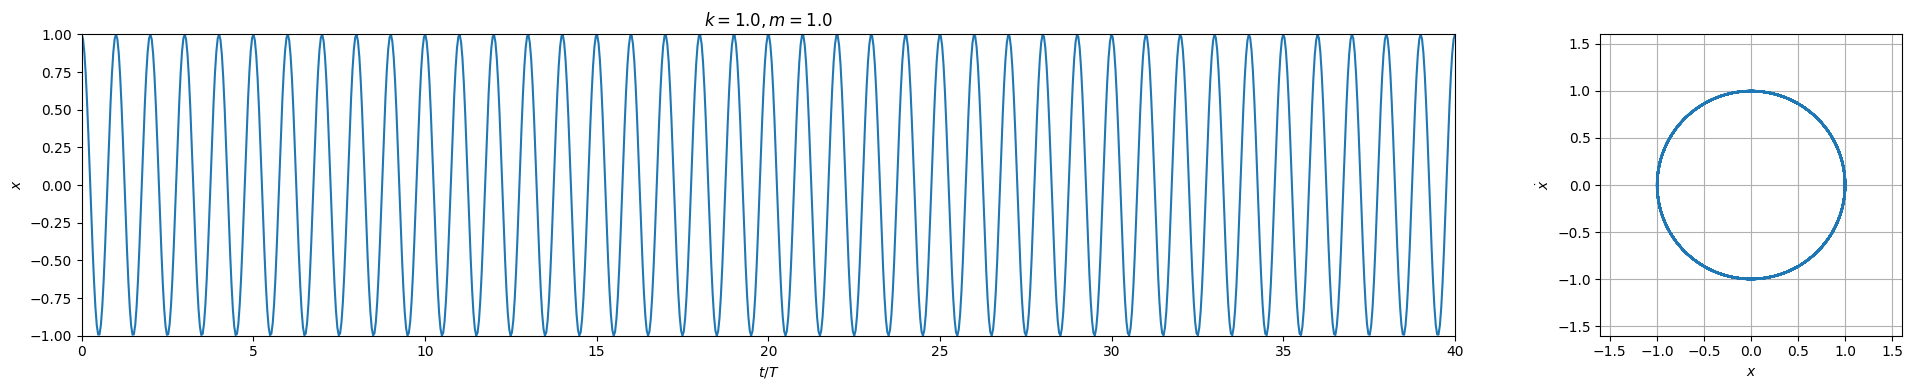

In [8]:
from matplotlib import gridspec

fig = plt.figure(figsize=(20, 4))

gs  = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax1.set_aspect(1)

ax0.plot(eval_times/T, a.sol(eval_times)[:, 0])
ax0.set_xlim(0.0, 40.0)
ax0.set_ylim(-1.0, 1.0)
ax0.set_xlabel(r"$t/T$")
ax0.set_ylabel(r"$x$")
ax0.set_title(r"$k={},m={}$".format(a.constants['k'], a.constants['m']))

ax1.plot(a.y[:, 0], a.y[:, 1])
ax1.set_xlim(-1.6, 1.6)
ax1.set_ylim(-1.6, 1.6)
ax1.set_xlabel(r"$x$")
ax1.set_ylabel(r"$\dot x$")
ax1.grid(which='major')
plt.tight_layout()

## Defining a Simple Neural Network

Now we can define a simple neural network, in this case a feed-forward network (or a dense network), to dampen the oscillations of the system. Specifically, we will treat the network as providing some continuous force `F` which will be applied at every timestep assuming no lag in the controller nor any discretisation issues

In [9]:
@de.rhs_prettifier(
    equ_repr="[vx, -k*x/m+NN(x)/m]",
    md_repr=r"""
$$
\frac{\mathrm{d}y}{\mathrm{dt}} = \begin{bmatrix}
   0            & 1 \\
   -\frac{k}{m} & 0
   \end{bmatrix} \cdot \vec y + \begin{bmatrix}
    0 \\
    (\mathcal{NN}(x)+\cos(4t+y_0))/m
   \end{bmatrix}
$$
"""
)
def loss_augmented_nn_rhs(t, state, k, m, nn_controller, **kwargs):
    base_dynamics_rhs = rhs(t, state[...,:2], k, m)
    neural_network_impulse = torch.func.functional_call(nn_controller, kwargs, (torch.cat([state, torch.atleast_1d(torch.as_tensor(t, dtype=state.dtype, device=state.device)).cos(), torch.atleast_1d(torch.as_tensor(t, dtype=state.dtype, device=state.device)).sin()], dim=-1),))
    neural_network_impulse = 32.0 * (neural_network_impulse[...,0] - neural_network_impulse[...,1])
    neural_network_impulse = torch.stack([
        torch.zeros_like(neural_network_impulse),
        (neural_network_impulse + torch.cos(t*4.0+state[...,0]))/m
    ])
    return torch.cat([
        base_dynamics_rhs + neural_network_impulse,
        state[...,:1]**2
    ], dim=-1)

In [10]:
print(loss_augmented_nn_rhs)
display(loss_augmented_nn_rhs)


$$
\frac{\mathrm{d}y}{\mathrm{dt}} = \begin{bmatrix}
   0            & 1 \\
   -\frac{k}{m} & 0
   \end{bmatrix} \cdot \vec y + \begin{bmatrix}
    0 \\
    (\mathcal{NN}(x)+\cos(4t+y_0))/m
   \end{bmatrix}
$$




$$
\frac{\mathrm{d}y}{\mathrm{dt}} = \begin{bmatrix}
   0            & 1 \\
   -\frac{k}{m} & 0
   \end{bmatrix} \cdot \vec y + \begin{bmatrix}
    0 \\
    (\mathcal{NN}(x)+\cos(4t+y_0))/m
   \end{bmatrix}
$$


As we would like to integrate the system differentiably we use `desolver.torch_ext.torch_solve_ivp` which handles the forward/backward AD passes memory efficiently.

Under the hood, `torch_solve_ivp` utilises the adjoint method for reverse-mode AD and the tangent linear method for forward-mode AD. Furthermore, with the way that it is written, `torch_solve_ivp` allows differentiating multiple times and therefore estimating higher order derivatives. As we're training a simple NN to dampen a driven oscillator with first-order gradient descent, we do not utilise these features in this notebook.

In [11]:
from desolver.torch_ext import torch_solve_ivp

In [12]:
y_init_nn = y_init.detach().clone().to('cuda' if torch.cuda.is_available() else 'cpu', torch.float32)
y_init_nn = torch.cat([
    y_init_nn,
    torch.zeros_like(y_init_nn[...,:1])
], dim=-1)

state_dim = y_init_nn.shape[0] + 2
hidden_dim = 32
output_dim = 2

simple_nn = torch.nn.Sequential(
    torch.nn.Linear(state_dim, hidden_dim),
    torch.nn.PReLU(),
    torch.nn.Linear(hidden_dim, hidden_dim),
    torch.nn.PReLU(),
    torch.nn.Linear(hidden_dim, hidden_dim),
    torch.nn.PReLU(),
    torch.nn.Linear(hidden_dim, hidden_dim),
    torch.nn.PReLU(),
    torch.nn.Linear(hidden_dim, output_dim),
    torch.nn.Softmax(dim=-1)
).to('cuda' if torch.cuda.is_available() else 'cpu')

def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=0.25)
        if hasattr(m, "bias"):
            torch.nn.init.constant_(m.bias, 0.1)
    elif isinstance(m, torch.nn.PReLU):
        torch.nn.init.uniform_(m.weight)
        
simple_nn.apply(weights_init)

params = dict(simple_nn.named_parameters())
optimizer = torch.optim.AdamW(params.values(), lr=4e-3, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=32)
number_of_steps = 128

def closure():
    optimizer.zero_grad()
    integrated_system = torch_solve_ivp(loss_augmented_nn_rhs, t_span=(t0, 4*T), y0=y_init_nn, method='RK87', args=(constants['k'], constants['m'], simple_nn), kwargs=params)
    # The loss is the integrated error over the timespan.
    # This penalises the network for taking more time to dampen the system
    loss = 0.025 * integrated_system.y[-1,-1] + 0.975 * integrated_system.y[-1, :4].square().sum()
    if loss.requires_grad:
        loss.backward()
    return loss

best_loss = torch.inf
best_params = copy.deepcopy(simple_nn.state_dict())

for step_idx in range(number_of_steps):
    loss = optimizer.step(closure).item()
    lr_scheduler.step(loss)
    if loss < best_loss:
        best_loss = loss
        best_params = copy.deepcopy(simple_nn.state_dict())
    print(f"[{step_idx+1}/{number_of_steps}] - loss: {loss:.4e}, best_loss: {best_loss:.4e}, lr: {optimizer.param_groups[0]['lr']:.4e}")

[1/128] - loss: 2.5203e+00, best_loss: 2.5203e+00, lr: 4.0000e-03
[2/128] - loss: 1.2289e+00, best_loss: 1.2289e+00, lr: 4.0000e-03
[3/128] - loss: 2.3315e+00, best_loss: 1.2289e+00, lr: 4.0000e-03
[4/128] - loss: 1.4732e+00, best_loss: 1.2289e+00, lr: 4.0000e-03
[5/128] - loss: 1.1987e+00, best_loss: 1.1987e+00, lr: 4.0000e-03
[6/128] - loss: 1.0807e+00, best_loss: 1.0807e+00, lr: 4.0000e-03
[7/128] - loss: 1.2554e+00, best_loss: 1.0807e+00, lr: 4.0000e-03
[8/128] - loss: 1.2769e+00, best_loss: 1.0807e+00, lr: 4.0000e-03
[9/128] - loss: 1.2847e+00, best_loss: 1.0807e+00, lr: 4.0000e-03
[10/128] - loss: 1.1582e+00, best_loss: 1.0807e+00, lr: 4.0000e-03
[11/128] - loss: 7.6988e-01, best_loss: 7.6988e-01, lr: 4.0000e-03
[12/128] - loss: 7.5957e-01, best_loss: 7.5957e-01, lr: 4.0000e-03
[13/128] - loss: 7.9783e-01, best_loss: 7.5957e-01, lr: 4.0000e-03
[14/128] - loss: 7.4240e-01, best_loss: 7.4240e-01, lr: 4.0000e-03
[15/128] - loss: 7.3861e-01, best_loss: 7.3861e-01, lr: 4.0000e-03
[16/

KeyboardInterrupt: 

In [ ]:
simple_nn.load_state_dict(best_params)

with torch.no_grad():
    a_nn = de.OdeSystem(loss_augmented_nn_rhs, y0=y_init_nn, dense_output=True, t=(t0, tf), constants={**constants, "nn_controller": simple_nn})
    a_nn.method = "RK87"
    a_nn.integrate()

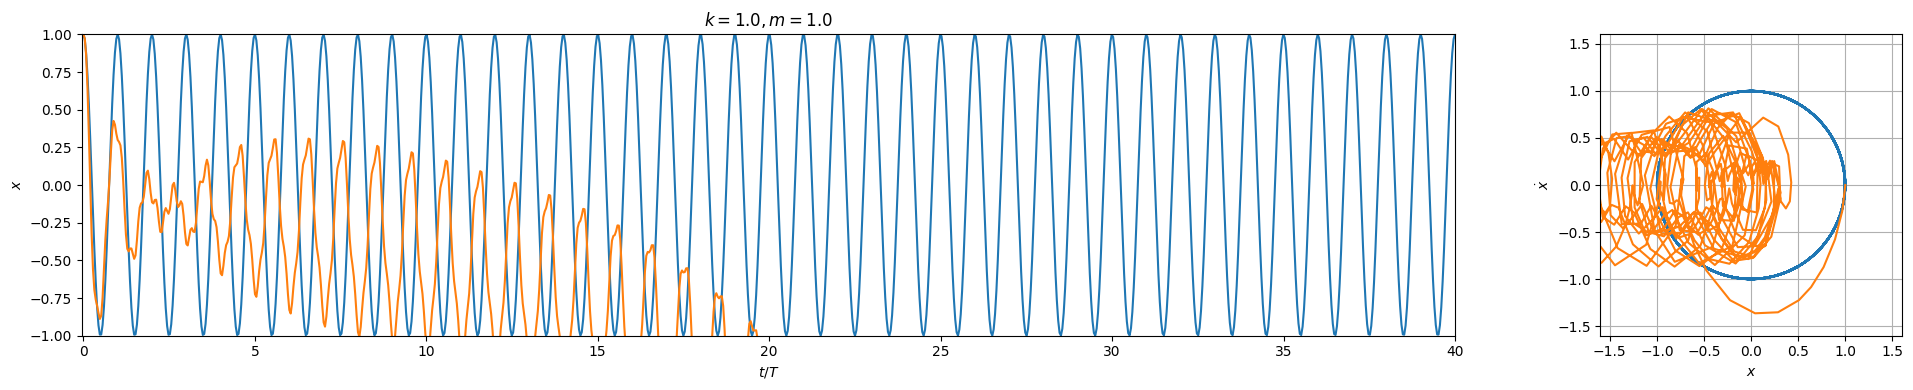

In [ ]:
fig = plt.figure(figsize=(20, 4))

gs  = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax1.set_aspect(1)

ax0.plot(eval_times/T, a.sol(eval_times)[:, 0], label="Without NN")
ax0.plot(eval_times/T, a_nn.sol(eval_times.to(a_nn.y)).cpu()[:, 0], label="With NN")
ax0.set_xlim(-0.05, 40.0)
ax0.set_ylim(-1.0, 1.0)
ax0.set_xlabel(r"$t/T$")
ax0.set_ylabel(r"$x$")
ax0.set_title(r"$k={},m={}$".format(a.constants['k'], a.constants['m']))

ax1.plot(a.y[:, 0], a.y[:, 1], label="Without NN")
ax1.plot(a_nn.y[:, 0].cpu(), a_nn.y[:, 1].cpu(), label="With NN")
ax1.set_xlim(-1.6, 1.6)
ax1.set_ylim(-1.6, 1.6)
ax1.set_xlabel(r"$x$")
ax1.set_ylabel(r"$\dot x$")
ax1.grid(which='major')
plt.tight_layout()